## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [153]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [155]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab Notebooks/complaints-2021-05-14_08_16.json', 'r') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [156]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [157]:
# Inspect the dataframe to understand the given data.
df.info()
print('\n')
print("The shape of the dataframe is: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [158]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [159]:
#Assign new column names
df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename(columns={'_index':'index', '_type':'type', '_id': 'id', '_score': 'score'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [160]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']=='']=np.nan

In [161]:
#Remove all rows where complaints column is nan
df=df.dropna(subset=['complaint_what_happened'])
df.reset_index(drop=True)
print('\n')
print("The shape of the dataframe is: ", df.shape)



The shape of the dataframe is:  (21072, 22)


In [162]:
df['complaint_what_happened']

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [163]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text=text.lower()
    text=re.sub(r'\[.*?\]', '', text)
    text=re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text=re.sub(r'\w*\d\w*', '', text)
    return text
clean_df=pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean_text(x)))

In [164]:
#Write your function to Lemmatize the texts
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(text):      
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [165]:
clean_df['lem_complaint'] = clean_df['complaint_what_happened'].apply(lambda x : lemmatize(x))

In [166]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'Complaints' : clean_df['complaint_what_happened'], 
                         'Lem_complaints' : clean_df['lem_complaint']})
print(df_clean.shape)

(21072, 2)


In [167]:
df_clean

,Complaints,Lem_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...


In [168]:
#Write your function to extract the POS tags 

def pos_tag(text):
  pos_removed = []
  doc = nlp(text)
  for tok in doc:
    if (tok.pos_=="NOUN"):
      pos_removed.append(tok.lemma_.lower())

  return " ".join(pos_removed)


df_clean["Complaint_POS_removed"] =  df_clean['Complaints'].apply(lambda x : pos_tag(x))


In [169]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Complaints             21072 non-null  object
 1   Lem_complaints         21072 non-null  object
 2   Complaint_POS_removed  21072 non-null  object
dtypes: object(3)
memory usage: 658.5+ KB


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Figure size 720x432 with 0 Axes>

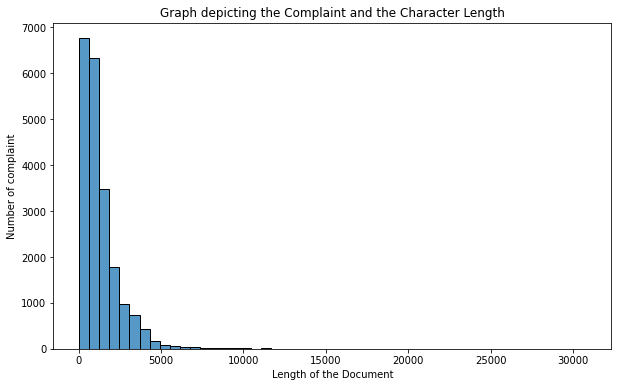

In [170]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
document_length=[len(doc) for doc in df_clean.Complaints]

plt.figure(figsize=(10,6))
sns.histplot(document_length, bins= 50)
plt.title("Graph depicting the Complaint and the Character Length")
plt.xlabel("Length of the Document")
plt.ylabel("Number of complaint")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

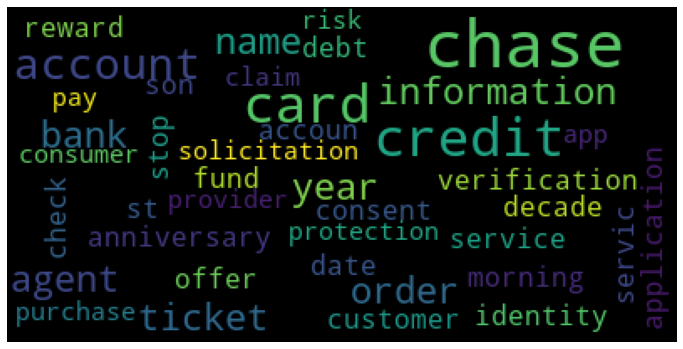

In [171]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

plt.rcParams['figure.figsize']=[12.0,12.0]
plt.rcParams['font.size']=12
plt.rcParams['savefig.dpi']=100
plt.rcParams['figure.subplot.bottom']=.1
stopwords=set(STOPWORDS)

wordcloud = WordCloud(background_color='black',
                     stopwords=stopwords,
                     max_words=40,
                     max_font_size=40,
                     random_state=42).generate(str(df_clean['Complaint_POS_removed']))

print(wordcloud)
fig=plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [172]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['Complaint_POS_removed'].str.replace('-PRON-', '')

In [173]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Complaints             21072 non-null  object
 1   Lem_complaints         21072 non-null  object
 2   Complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
dtypes: object(4)
memory usage: 823.1+ KB


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [174]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_n_words(corpus, n=None):
    vec=CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words=vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True )
    return words_freq[:n]
common_words=get_top_n_words(df_clean['Complaint_clean'].values.astype('U'),50)
df_freq=pd.DataFrame(common_words,columns=['unigram', 'count'])

fig=go.Figure([go.Bar(x=df_freq['unigram'], y=df_freq['count'])])
fig.update_layout(title=go.layout.Title(text='Top 50 unigrams in the Complaint text after removing stop words and lemmatization')) 
fig.show()

In [175]:
#Print the top 10 words in the unigram frequency
df_freq.head(10)

,unigram,count
0,chase,62896
1,account,46145
2,credit,32299
3,card,29945
4,payment,21092
5,bank,18210
6,time,16004
7,day,12938
8,charge,12068
9,money,11954


In [176]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec=CountVectorizer(stop_words='english',ngram_range=(2, 2)).fit(corpus)
    bag_of_words=vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True )
    return words_freq[:n]

common_words=get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'),50)
df_bigram=pd.DataFrame(common_words,columns=['bigram', 'count'])

fig=go.Figure([go.Bar(x=df_bigram['bigram'], y=df_bigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 50 bigram in the Complaint text after removing stop words and lemmatization')) 
fig.show()

In [177]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12658
1,account chase,3824
2,credit report,3803
3,chase credit,3680
4,checking account,3183
5,chase account,3107
6,chase bank,3095
7,customer service,2986
8,account account,2733
9,bank account,2249


In [178]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus,n=None):
    vec=CountVectorizer(stop_words='english',ngram_range=(3, 3)).fit(corpus)
    bag_of_words=vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    words_freq=[(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq, key= lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words=get_top_n_trigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df_trigram=pd.DataFrame(common_words, columns=['trigram', 'count'])

fig=go.Figure([go.Bar(x=df_trigram['trigram'], y=df_trigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 50 trigram in the Complaint text after removing stop words and lemmatization')) 
fig.show()

In [179]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2494
1,credit card account,1020
2,credit card company,1003
3,credit card chase,923
4,chase customer service,608
5,credit card credit,583
6,inquiry credit report,548
7,card credit card,462
8,chase checking account,459
9,account credit card,437


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [180]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [183]:
#All masked texts has been removed
df_clean

,Complaints,Lem_complaints,Complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop service debt verification st...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,agent anniversary date agent information order...,agent anniversary date agent information order...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [184]:
#Write your code here to initialise the TfidfVectorizer 
tfidf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

tf_fit = tfidf_vect.fit(df_clean.Complaint_clean)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [185]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tf_fit.transform(df_clean.Complaint_clean)
dtm

<21072x6227 sparse matrix of type '<class 'numpy.float64'>'
	with 550791 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [186]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [187]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40) 

In [188]:
nmf_model.fit(dtm)
len(tfidf_vect.get_feature_names())

6227

In [189]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['claim', 'fee', 'business', 'number', 'transaction', 'branch', 'day', 'deposit', 'checking', 'fund', 'chase', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['company', 'customer', 'claim', 'time', 'fee', 'merchant', 'service', 'fraud', 'purchase', 'dispute', 'transaction', 'credit', 'chase', 'charge', 'card']


THE TOP 15 WORDS FOR TOPIC #2
['car', 'error', 'account', 'year', 'auto', 'credit', 'date', 'chase', 'time', 'day', 'statement', 'month', 'fee', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['chase', 'bureaus', 'identity', 'limit', 'application', 'reporting', 'information', 'debt', 'company', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


THE TOP 15 WORDS FOR TOPIC #4
['information', 'sale', 'house', 'foreclosure', 'time', 'rate', 'document', 'letter', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']




In [190]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results=nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([4, 0, 3, ..., 1, 2, 2])

In [191]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [192]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Complaints             21072 non-null  object
 1   Lem_complaints         21072 non-null  object
 2   Complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 987.8+ KB


In [193]:
#Print the first 5 Complaint for each of the Topics
df_clean_topic=df_clean.groupby('Topic').head(5)
df_clean_topic.sort_values('Topic')

,Complaints,Lem_complaints,Complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account code bonus term account deposit bonus ...,account code bonus term account deposit bonus ...,0
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice chase account debit card branch custome...,notice chase account debit card branch custome...,0
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,account chase auto,0
45,i made a purchase with xxxx xxxx xxxx on in t...,made purchase xxxx xxxx xxxx amount charged tw...,purchase amount transaction dispute case charg...,purchase amount transaction dispute case charg...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,sofa love seat table chair debit card bank cla...,sofa love seat table chair debit card bank cla...,1
21,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using chase ...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
32,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1
30,to whom it may concern chase bank charged wron...,may concern chase bank charged wrongly overdra...,concern overdraft fee alert balance fee balanc...,concern overdraft fee alert balance fee balanc...,1


In [194]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Complaints             21072 non-null  object
 1   Lem_complaints         21072 non-null  object
 2   Complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 987.8+ KB


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [195]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account services', 1:'Credit card or prepaid card', 
               2:'Others', 3:'Theft/Dispute Reporting', 4:'Mortgage/Loan'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [196]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Complaints             21072 non-null  object
 1   Lem_complaints         21072 non-null  object
 2   Complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  object
dtypes: object(5)
memory usage: 987.8+ KB


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [197]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account services':0, 'Credit card or prepaid card':1, 'Others':2,'Theft/Dispute Reporting':3,'Mortgage/Loan':4}
#Replace Topics with Topic Names
df_clean['Topics'] = df_clean['Topic'].map(Topic_names)

In [200]:
df_clean

,Complaints,Lem_complaints,Complaint_POS_removed,Complaint_clean,Topic,Topics
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop service debt verification st...,morning name stop service debt verification st...,Mortgage/Loan,4
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,agent anniversary date agent information order...,agent anniversary date agent information order...,Bank Account services,0
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,chase card application identity consent servic...,Theft/Dispute Reporting,3
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute Reporting,3
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Bank Account services,0
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card or prepaid card,1
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Credit card or prepaid card,1
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Others,2


In [201]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["Complaints","Topics"]]

In [202]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Complaints  21072 non-null  object
 1   Topics      21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 493.9+ KB


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [206]:

#Write your code to get the Vector count
count_vect = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
train_counts = count_vect.fit_transform(training_data['Complaints'])

#Write your code here to transform the word vector to tf-idf

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
word_vect = tfidf_transformer.transform(train_counts)
word_vect.shape


(21072, 820)

In [207]:
columns = count_vect.get_feature_names_out()
print("Feature columns: ", len(columns))

Feature columns:  820


In [209]:
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=count_vect.get_feature_names_out(),index=training_data.index)
word_vect_df.head()

,ability,able,absolutely,accept,accepted,access,according,account,account called,account chase,...,xxxxxxxx chase,xxxxxxxx received,xxxxxxxx xxxx,xxxxxxxx xxxx xxxx,xxxxxxxx xxxxxxxx,xxxxxxxxxxxx,year,years,years ago,yes
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062762,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.077125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.184686,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.111602,0.0,0.0,0.0,0.0,0.107662,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125583,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [210]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Complaints  21072 non-null  object
 1   Topics      21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 493.9+ KB


In [212]:
# Assign the label to be matched
word_vect_df["Topics"] = training_data["Topics"]

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# 1 - Logistic Regression:

In [213]:
# Common function to evaluate the matrix

from sklearn import metrics

def evaluate_accuracy(y_actual, y_pred):
    
    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    
    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    clf_report = metrics.classification_report(y_actual, y_pred) # Sklearn classification report
    
    print("Accuracy: " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("\nClassification Report:")
    print(clf_report)

In [215]:
#Splitting to train & test:
from sklearn.model_selection import train_test_split

X = word_vect_df.drop(['Topics'], axis=1)
y = word_vect_df['Topics']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=40, stratify=y)

In [216]:
# Building the model:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_regression.fit(X_train, y_train)

y_train_pred_lr = logistic_regression.predict(X_train)
y_test_pred_lr = logistic_regression.predict(X_test)

In [217]:
# Check for model training accuracy
train_accuracy_lr = evaluate_accuracy(y_train.values, y_train_pred_lr)

Accuracy: 0.9608813559322034

Confusion matrix:
 [[3907   59    4   19   17]
 [  73 4049    8   20   18]
 [  39   43 1626    6   35]
 [  32   70    9 1997   19]
 [  40   37   14   15 2594]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4006
           1       0.95      0.97      0.96      4168
           2       0.98      0.93      0.95      1749
           3       0.97      0.94      0.95      2127
           4       0.97      0.96      0.96      2700

    accuracy                           0.96     14750
   macro avg       0.96      0.96      0.96     14750
weighted avg       0.96      0.96      0.96     14750



In [218]:
# Check for model test accuracy
test_accuracy_lr = evaluate_accuracy(y_test.values, y_test_pred_lr)

Accuracy: 0.9315090161341347

Confusion matrix:
 [[1632   51    4    8   22]
 [  58 1701    4   18    6]
 [  27   26  662   11   23]
 [  22   55    4  815   16]
 [  31   22    7   18 1079]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1717
           1       0.92      0.95      0.93      1787
           2       0.97      0.88      0.93       749
           3       0.94      0.89      0.91       912
           4       0.94      0.93      0.94      1157

    accuracy                           0.93      6322
   macro avg       0.94      0.92      0.93      6322
weighted avg       0.93      0.93      0.93      6322



#2 - Decision Tree 

In [220]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
dt = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
dt.fit(X_train,y_train)

# Predict the train and test
y_train_pred_dt  = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

In [221]:
# Check for model training accuracy
train_accuracy_dt = evaluate_accuracy(y_train.values, y_train_pred_dt)

Accuracy: 0.8113898305084746

Confusion matrix:
 [[3238  248   90  121  309]
 [ 232 3068   95  297  476]
 [  48   36 1521   40  104]
 [  54  136   40 1757  140]
 [  93   50   84   89 2384]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4006
           1       0.87      0.74      0.80      4168
           2       0.83      0.87      0.85      1749
           3       0.76      0.83      0.79      2127
           4       0.70      0.88      0.78      2700

    accuracy                           0.81     14750
   macro avg       0.81      0.82      0.81     14750
weighted avg       0.82      0.81      0.81     14750



In [222]:
# Check for model test accuracy
test_accuracy_dt = evaluate_accuracy(y_test.values, y_test_pred_dt)

Accuracy: 0.7783929136349257

Confusion matrix:
 [[1322  122   60   50  163]
 [ 115 1298   48  138  188]
 [  22   23  616   28   60]
 [  38   97   19  717   41]
 [  55   26   61   47  968]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1717
           1       0.83      0.73      0.77      1787
           2       0.77      0.82      0.79       749
           3       0.73      0.79      0.76       912
           4       0.68      0.84      0.75      1157

    accuracy                           0.78      6322
   macro avg       0.77      0.79      0.78      6322
weighted avg       0.79      0.78      0.78      6322



In [223]:
#decission tree with hyper parameter tuning with GRID SEARCH CV
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state = 40, class_weight="balanced")

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["entropy", "gini"]
}

grid_search = GridSearchCV(estimator = dt,param_grid = params,cv = 5, n_jobs=-1, verbose=1, scoring="accuracy", return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=40),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 50]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [224]:
#getting best params:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 10}

In [225]:
#Decision tree with new parameters obtained from grid Search CV"
dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [226]:
# Check for model training accuracy
train_accuracy_dtht = evaluate_accuracy(y_train.values,y_train_pred_dt)

Accuracy: 0.8663050847457627

Confusion matrix:
 [[3466  196   87  112  145]
 [ 171 3442  129  233  193]
 [  39   23 1579   39   69]
 [  36   97   40 1901   53]
 [  86   45   91   88 2390]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4006
           1       0.91      0.83      0.86      4168
           2       0.82      0.90      0.86      1749
           3       0.80      0.89      0.84      2127
           4       0.84      0.89      0.86      2700

    accuracy                           0.87     14750
   macro avg       0.86      0.87      0.86     14750
weighted avg       0.87      0.87      0.87     14750



In [227]:
# Check for model test accuracy
test_accuracy_dtht = evaluate_accuracy(y_test.values, y_test_pred_dt)

Accuracy: 0.8037013603290099

Confusion matrix:
 [[1374  137   68   54   84]
 [ 124 1391   69  122   81]
 [  27   20  626   33   43]
 [  30  107   21  733   21]
 [  63   26   66   45  957]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1717
           1       0.83      0.78      0.80      1787
           2       0.74      0.84      0.78       749
           3       0.74      0.80      0.77       912
           4       0.81      0.83      0.82      1157

    accuracy                           0.80      6322
   macro avg       0.79      0.81      0.80      6322
weighted avg       0.81      0.80      0.80      6322



#3 - Random Forest

In [228]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier(random_state=42, class_weight="balanced")

folds = StratifiedKFold(n_splits=4, shuffle = True, random_state=40)

param_grid = {
     'max_depth': [5, 10, 20],
     'min_samples_leaf': [10, 20, 50, 100],
     'n_estimators': [15, 20, 25, 30],
     'min_samples_split': range(10, 30, 50),
     'max_features': [5, 10, 15],
     'criterion': ["gini"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = folds, verbose = 1, scoring="accuracy", return_train_score=True)

In [229]:
# Fit the grid search to the data, This step may take a lot of time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=40, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 20],
                         'max_features': [5, 10, 15],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'min_samples_split': range(10, 30, 50),
                         'n_estimators': [15, 20, 25, 30]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [230]:
#finding the best estimator:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=15,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=30, random_state=42)

In [231]:
#fitting x train & Ytrain with best from grid search:
rf_best.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=15,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=30, random_state=42)

In [232]:
#making predictions:
y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [233]:
# Check for model training accuracy
train_accuracy_rf = evaluate_accuracy(y_train.values,y_train_pred_rf)

Accuracy: 0.8862372881355932

Confusion matrix:
 [[3665  122   55   77   87]
 [ 236 3555   94  184   99]
 [  83   36 1503   27  100]
 [  29   73   40 1947   38]
 [  69   66   86   77 2402]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4006
           1       0.92      0.85      0.89      4168
           2       0.85      0.86      0.85      1749
           3       0.84      0.92      0.88      2127
           4       0.88      0.89      0.89      2700

    accuracy                           0.89     14750
   macro avg       0.88      0.89      0.88     14750
weighted avg       0.89      0.89      0.89     14750



In [234]:
# Check for model test accuracy
test_accuracy_rf = evaluate_accuracy(y_test.values, y_test_pred_rf)

Accuracy: 0.8427712749130022

Confusion matrix:
 [[1515   75   34   33   60]
 [ 140 1454   53   99   41]
 [  45   33  568   36   67]
 [  17   71   16  789   19]
 [  36   27   50   42 1002]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1717
           1       0.88      0.81      0.84      1787
           2       0.79      0.76      0.77       749
           3       0.79      0.87      0.83       912
           4       0.84      0.87      0.85      1157

    accuracy                           0.84      6322
   macro avg       0.83      0.84      0.83      6322
weighted avg       0.84      0.84      0.84      6322



#MODEL EVALUATION & CONCLUSION:

In [244]:
# Write your code here to build any 4 models and evaluate them using the required metrics

performance_metrics = pd.DataFrame(
    {'Model': ['Logistic Regression', 
               'Decision Tree',
               'Decision Tree with Hyperparameter tuning',
               'Random-Forest'],
     'Training Accuracy': ['0.96', 
                           '0.81',
                           '0.86', 
                           '0.88'],
     'Test Accuracy': ['0.93',
                       '0.77',
                       '0.80',
                       '0.84']}
    )

performance_metrics

,Model,Training Accuracy,Test Accuracy
0,Logistic Regression,0.96,0.93
1,Decision Tree,0.81,0.77
2,Decision Tree with Hyperparameter tuning,0.86,0.80
3,Random-Forest,0.88,0.84


CONCLUSION: Of all the models used Logistic Regression explains and intreprets the data and predicts in an very balanced manner with respect to BIAS & VARIENCE. So Logiestic Regression is the BEST MODEL.